In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
from mppi import InputFiles as I, Calculators as C, Datasets as D, Utilities as U, Parsers as P
from mppi.Models import TwoLevelSystems as TLS
from mppi.Utilities import Constants as Const
import matplotlib.pyplot as plt
import numpy as np
import os, yaml

h_red = Const.Planck_reduced_ev_ps*1e3 # hbar in eV*fs
h = Const.Planck_ev_ps*1e3 # h in eV*fs

In [5]:
omp = 1
mpi = 16
sbatch_options = ['--partition=all12h'] #,'--ntasks-per-node=16']

In [4]:
#code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt')
code = C.YamboCalculator(omp=omp,mpi=mpi,executable='yambo_rt',scheduler='slurm',sbatch_options=sbatch_options)
code.global_options()

Initialize a Yambo calculator with scheduler slurm


{'omp': 1,
 'mpi': 4,
 'mpi_run': 'mpirun -np',
 'executable': 'yambo_rt',
 'scheduler': 'slurm',
 'skip': True,
 'clean_restart': True,
 'dry_run': False,
 'wait_end_run': True,
 'sbatch_options': ['--partition=all12h'],
 'activate_BeeOND': True,
 'verbose': True}

# Computation of the IP Absorption spectrum

We compute the IP absorption spectrum using Yambo

In [6]:
# analysis with k sampling volume of 0.06 (1000 points)     
run_dir = 'ABS-IP_k1000_kspan0.06'
source_dir = 'NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.06.save'

In [7]:
U.build_SAVE(source_dir,run_dir,make_link=True)

Create folder ABS-IP_k1000_kspan0.06
Executing command: cd NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.06.save; p2y -a 2
Create a symlink of /work/dalessandro/OPTICAL_ORIENTATION/Echo_mechanisms_decay_time/PHOTON_ECO/NSCF/bnds_8-kpoints_1000-sampling_random_close_Gamma_kspan0.06.save/SAVE in ABS-IP_k1000_kspan0.06
Executing command: cd ABS-IP_k1000_kspan0.06;OMP_NUM_THREADS=1 yambo


In [8]:
h/250

0.016542670784

In [9]:
T2 = 250 # damping time in fs
eta = h / T2 # eta damping in eV 

inp = I.YamboInput('yambo -o c',folder=run_dir)
inp['variables']['LongDrXd'] = [[1.00,1.00,1.00],''] # electric field
inp['variables']['XfnQP_E'] = [[0.95477,1.00,1.00],''] # scissor
inp['variables']['DmRngeXd'] = [[eta/2,eta/2],'eV'] # damping range
inp['variables']['EnRngeXd'] = [[0,6],'eV'] # energy range
inp['variables']['BndsRnXd'] = [[2,8],''] # bands used for transitions
inp['variables']['QpntsRXd'] = [[1,1],''] # momentum transfer
inp

{'args': 'yambo -o c',
 'folder': 'ABS-IP_k1000_kspan0.06',
 'filename': 'yambo.in',
 'arguments': ['chi', 'optics'],
 'variables': {'X_Threads': [0.0, ''],
  'DIP_Threads': [0.0, ''],
  'ETStpsXd': [100.0, ''],
  'Chimod': 'IP',
  'QpntsRXd': [[1, 1], ''],
  'BndsRnXd': [[2, 8], ''],
  'EnRngeXd': [[0, 6], 'eV'],
  'DmRngeXd': [[0.008271335392, 0.008271335392], 'eV'],
  'LongDrXd': [[1.0, 1.0, 1.0], ''],
  'XfnQP_E': [[0.95477, 1.0, 1.0], '']}}

In [10]:
name = 'ip_abs'
result = code.run(input=inp,name=name,run_dir=run_dir,skip=False)
result

run command: mpirun -np 4 yambo_rt -F ip_abs.in -J ip_abs -C ip_abs
slurm submit:  cd ABS-IP_k1000_kspan0.06 ; sbatch job_ip_abs.sh
computation ip_abs is running...
computation ip_abs ended
Run performed in 36s


{'output': ['ABS-IP_k1000_kspan0.06/ip_abs/o-ip_abs.eps_q1_ip',
  'ABS-IP_k1000_kspan0.06/ip_abs/o-ip_abs.eel_q1_ip'],
 'report': 'ABS-IP_k1000_kspan0.06/ip_abs/r-ip_abs_optics_chi',
 'dft': 'ABS-IP_k1000_kspan0.06/SAVE/ns.db1',
 'dipoles': 'ABS-IP_k1000_kspan0.06/ip_abs/ndb.dipoles'}

In [12]:
data = P.YamboParser(result)

In [15]:
#data = P.YamboParser(result['output'][0])

In [20]:
eps = data.data['eps_q1_ip']
energy = eps['col0']
eps_im = eps['col1']
eps_re = eps['col2']

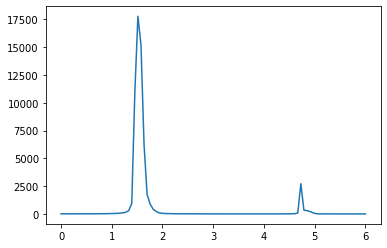

In [21]:
plt.plot(energy,eps_im)